Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [07:28:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'rf__n_estimators': 100, 'rf__max_depth': 15, 'gb__n_estimators': 200, 'gb__learning_rate': 0.1}
Best CV Accuracy: 0.9649122807017543

Final Accuracy: 1.0
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       212
           1       1.00      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569



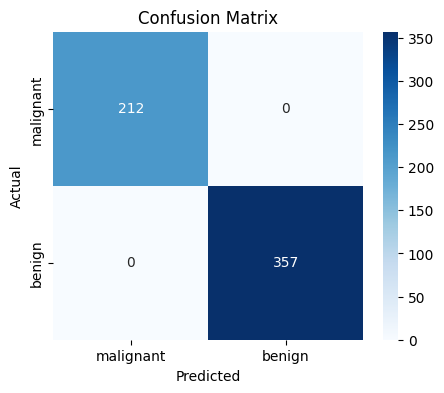

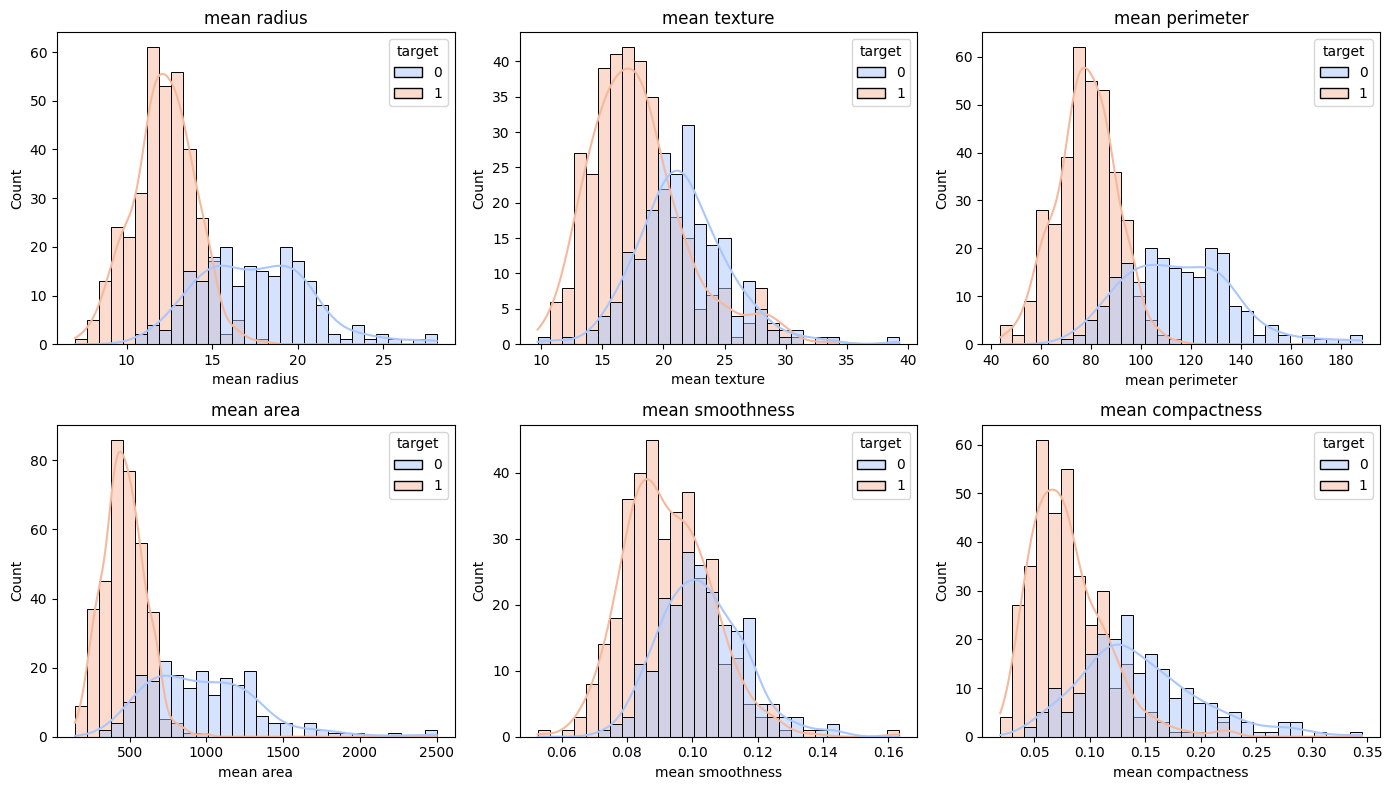

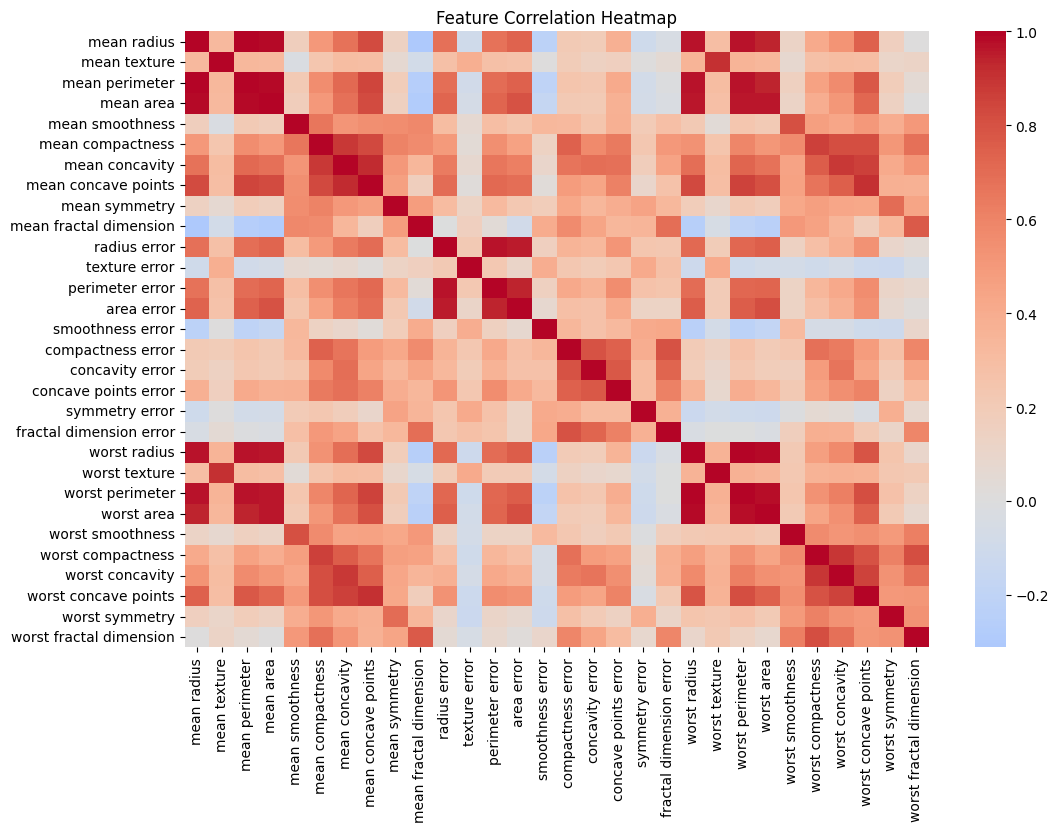

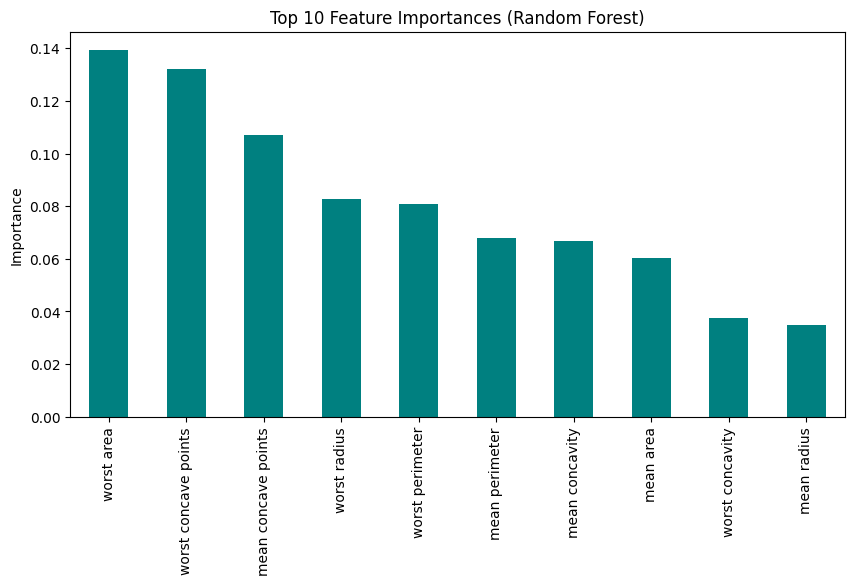

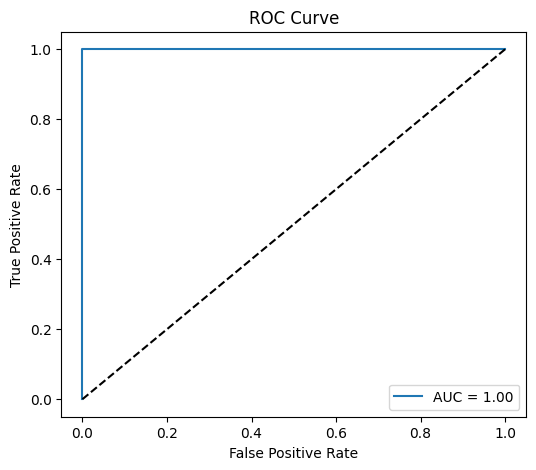

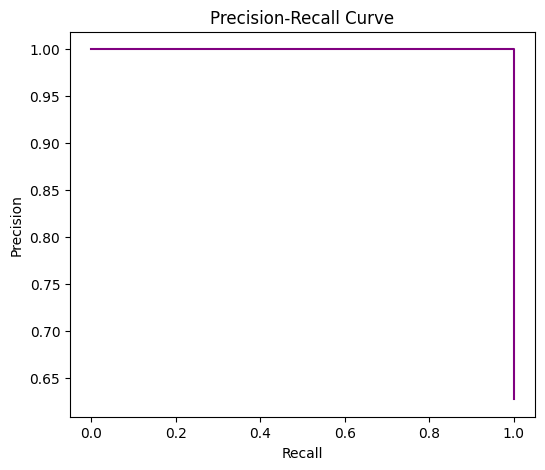

In [3]:
# ================================
# Advanced Binary Classification with Visualizations
# Breast Cancer Wisconsin Dataset
# ================================

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------
# 1. Load Dataset
# -----------------
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# -----------------
# 2. Preprocessing
# -----------------
if X.isnull().sum().any():
    X.fillna(X.mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------
# 3. Define Models
# -----------------
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('gb', gb), ('xgb', xgb)],
    voting='soft'
)

# -----------------
# 4. Hyperparameter Tuning
# -----------------
param_grid = {
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [None, 5, 10, 15],
    'gb__n_estimators': [100, 200],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=voting_clf,
    param_distributions=param_grid,
    n_iter=20,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# -----------------
# 5. Fit Model
# -----------------
search.fit(X_scaled, y)
best_model = search.best_estimator_

print("Best Parameters:", search.best_params_)
print("Best CV Accuracy:", search.best_score_)

# -----------------
# 6. Final Evaluation
# -----------------
y_pred = best_model.predict(X_scaled)
print("\nFinal Accuracy:", accuracy_score(y, y_pred))
print("ROC AUC:", roc_auc_score(y, best_model.predict_proba(X_scaled)[:, 1]))
print("\nClassification Report:\n", classification_report(y, y_pred))

# -----------------
# 7. Visualizations
# -----------------

# (1) Confusion Matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# (2) Feature Distributions
plt.figure(figsize=(14, 8))
for i, col in enumerate(data.feature_names[:6]):  # first 6 features
    plt.subplot(2, 3, i+1)
    sns.histplot(x=X[col], hue=y, bins=30, palette="coolwarm", kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# (3) Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X_scaled, columns=data.feature_names).corr(),
            cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# (4) Feature Importance (Random Forest from Voting Classifier)
rf_model = best_model.named_estimators_['rf']
importances = pd.Series(rf_model.feature_importances_, index=data.feature_names)
importances.sort_values(ascending=False)[:10].plot(kind='bar', figsize=(10, 5), color='teal')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.show()

# (5) ROC Curve
y_proba = best_model.predict_proba(X_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_proba):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# (6) Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()
